In [0]:
import gym
import numpy as np
import torch
import random
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import copy
from collections import deque
import matplotlib.pyplot as plt

In [0]:
BUF_SIZE = 10000
BATCH_SIZE = 128
UPDATE_TARGET = 500 # Обновляем target сетку раз в UPDATE_TARGET обновлений основной сетки
GAMMA = 0.98

In [0]:
seed = 17
np.random.seed(seed)
random.seed(seed)
env = gym.make('MountainCar-v0')
env.seed(seed)
torch.manual_seed(seed)

In [0]:
def transform_state(state):
    state = (np.array(state) + np.array((1.2, 0.0))) / np.array((1.8, 0.07))
    result = []
    result.extend(state)
    return np.array(state)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Агент для игры

In [0]:
class Agent:
    def __init__(self, model):
        self.model = copy.deepcopy(model)

    def act(self, state):
        state = torch.tensor(transform_state(state)).to(device).float()
        with torch.no_grad():
            Q_values = self.model(state.unsqueeze(0))
        return np.argmax(Q_values.cpu().data.numpy())

    def reset(self):
        pass

# Очередь

Мы хотим очередь, но в которой можно по-нормальному извлекать батч.

In [0]:
class Buffer:
    def __init__(self, cap):
        self.cap = cap
        self.mem = []
        self.pos = -1  # позиция последнего записанного элемента

    def __len__(self):
        return len(self.mem)

    def add(self, element):
        if len(self.mem) < self.cap:
            self.mem.append(None)
        new_pos = (self.pos + 1) % self.cap
        self.mem[new_pos] = element
        self.pos = new_pos

    def sample(self, batch_size):
        return random.sample(self.mem, batch_size)
        
    def __getitem__(self, k):
        return self.mem[(self.pos + 1 + k) % self.cap]

# Сетка для DQN

In [0]:
class Model(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        lin1 = nn.Linear(state_dim,64)
        torch.nn.init.xavier_normal_(lin1.weight)

        lin2 = nn.Linear(64, 64)
        torch.nn.init.xavier_normal_(lin2.weight)

        lin3 = nn.Linear(64, action_dim)
        torch.nn.init.xavier_normal_(lin3.weight)

        self.layers = nn.Sequential(lin1, nn.ReLU(), lin2, nn.ReLU(), lin3)

    def forward(self, x):
        return self.layers(x)

# DQN

In [0]:
class DQN:
    def __init__(self, state_dim, action_dim):
        self.network = Model(state_dim, action_dim).to(device)
        self.target_network = copy.deepcopy(self.network).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=5e-4)

    def update(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.from_numpy(np.array(states)).float().to(device)
        actions = torch.from_numpy(np.array(actions)).to(device).unsqueeze(1)
        rewards = torch.from_numpy(np.array(rewards)).float().to(device).unsqueeze(1)
        next_states = torch.from_numpy(np.array(next_states)).float().to(device)
        dones = torch.from_numpy(np.array(dones)).to(device).unsqueeze(1)

        with torch.no_grad(): # Double DQN  
            argmax = self.network(next_states).detach().max(1)[1].unsqueeze(1)
            target = rewards + (GAMMA * self.target_network(next_states).detach().gather(1, argmax))*(~dones)

        Q_current = self.network(states).gather(1, actions)
        self.optimizer.zero_grad()
        loss = F.mse_loss(target, Q_current)
        loss.backward()
        self.optimizer.step()
        
    def act(self, state):
        state = torch.tensor(state).to(device).float()
        with torch.no_grad():
            Q_values = self.network(state.unsqueeze(0))
        return np.argmax(Q_values.cpu().data.numpy())

    def update_target(self):
        self.target_network = copy.deepcopy(self.network)

# Обучение

In [0]:
def eps_greedy(env, dqn, state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    return dqn.act(state)


def current_results(i, rews, eps, output_period=100):
    mean_r = np.mean(rews)
    max_r = np.max(rews)
    min_r = np.min(rews)
    print(f'\repisode {i}, eps = {eps}, mean = {mean_r}, min = {min_r}, max = {max_r}', end="")
    if not i % output_period:
        print(f'\repisode {i}, eps = {eps}, mean = {mean_r}, min = {min_r}, max = {max_r}')
    return mean_r

In [0]:
dqn = DQN(state_dim=2, action_dim=3)
buf = Buffer(BUF_SIZE)

episodes = 1500
eps = 1
eps_coeff = 0.995
dqn_updates = 0
output_period = 100

rews = deque(maxlen=output_period) # сюда буду писать данные за output_period эпизодов
best_mean = -10 ** 3
best_model = None

# Задача считается решенной, когда среднее за 100 подряд идущих эпизодов >= -110
solv_ep = 10000
solv_mean = -200
rews_all = [None] * episodes # Буду писать сюда награды за каждый эпизод, чтобы потом нарисовать график

for i in range(1, episodes + 1):
    state = transform_state(env.reset())
    done = False
    total_reward = 0
    while not done:
        action = eps_greedy(env, dqn, state, eps)
        next_state, reward, done, _ = env.step(action)
        next_state = transform_state(next_state)
        total_reward += reward
        reward += 300 * (GAMMA * abs(next_state[1]) - abs(state[1]))
        buf.add((state, action, reward, next_state, done))
        if len(buf) >= BATCH_SIZE:
            dqn.update(buf.sample(BATCH_SIZE))
            dqn_updates += 1
        if not dqn_updates % UPDATE_TARGET:
            dqn.update_target()
        state = next_state
    eps *= eps_coeff
    rews.append(total_reward)
    rews_all[i - 1] = total_reward
    mean_r = current_results(i, rews, eps, output_period)
    if mean_r > best_mean:
        best_model = copy.deepcopy(dqn.network)
        best_mean = mean_r
    if mean_r > -110 and i < solv_ep:
        solv_ep = i
        solv_mean = mean_r


episode 100, eps = 0.6057704364907278, mean = -200.0, min = -200.0, max = -200.0
episode 200, eps = 0.3669578217261671, mean = -199.05, min = -200.0, max = -159.0
episode 300, eps = 0.22229219984074702, mean = -183.21, min = -200.0, max = -127.0
episode 400, eps = 0.1346580429260134, mean = -165.63, min = -200.0, max = -113.0
episode 500, eps = 0.08157186144027828, mean = -167.23, min = -200.0, max = -91.0
episode 600, eps = 0.0494138221100385, mean = -144.95, min = -200.0, max = -97.0
episode 700, eps = 0.029933432588273214, mean = -138.29, min = -200.0, max = -85.0
episode 800, eps = 0.018132788524664028, mean = -122.74, min = -175.0, max = -92.0
episode 900, eps = 0.01098430721937979, mean = -109.87, min = -159.0, max = -84.0
episode 1000, eps = 0.006653968578831948, mean = -107.93, min = -170.0, max = -83.0
episode 1100, eps = 0.004030777450394616, mean = -107.93, min = -199.0, max = -84.0
episode 1200, eps = 0.002441725815522529, mean = -104.07, min = -173.0, max = -83.0
episode 1

In [0]:
print(f"Problem solved on episode {solv_ep}, mean = {solv_mean}")

Problem solved on episode 900, mean = -109.87


# График: награда и число эпизодов

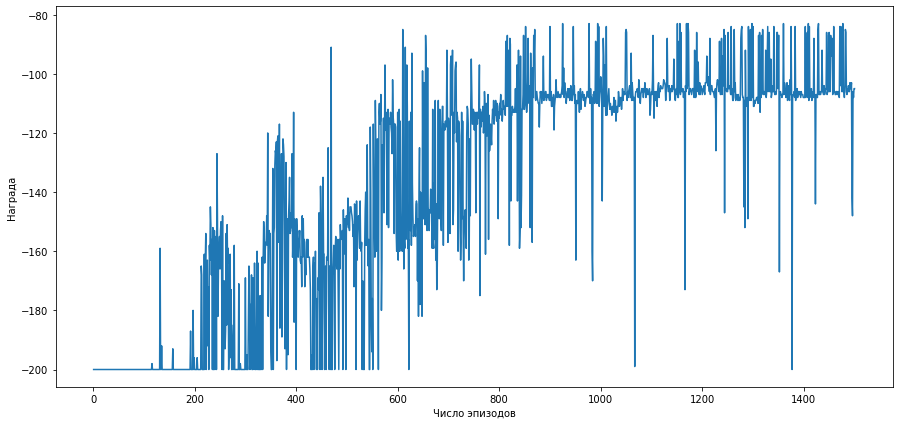

In [0]:
plt.figure(figsize=(15, 7))
plt.plot(range(1, episodes + 1), rews_all)
plt.ylabel('Награда')
plt.xlabel('Число эпизодов')
plt.show()